In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

# Discussion: Week 8

In this Notebook, we will investigate how the degree to which the central bank responds to changes inflation affects how exogenous shocks to demand or inflation propagate.


## The New-Keynesian Model

The most basic version of the New-Keynesian Model can be expressed as:

\begin{align}
y_t & = E_t y_{t+1}  - \left( r_{t} - \bar{r}\right) + g_t\\
i_{t} & = r_{t} + E_t \pi_{t+1}\\
i_{t} & = \bar{r} + \pi^T + \phi_{\pi}\big(\pi_t - \pi^T\big) + \phi_{y}\big(y_t - \bar{y}\big)\\
\pi_t -\pi^T & = \beta \left( E_t\pi_{t+1} - \pi^T\right)  + \kappa (y_t -\bar{y})+ u_t,
\end{align}

where: $y_t$ is (log) output, $r_t$ is the real interest rate, $i_t$ is the nominal interest rate, $\pi_t$ is the rate of inflation between periods $t-1$ and $t$, $\bar{r}$ is the long-run average real interest rate or the *natural rate of interest*, $\beta$ is the household's subjective discount factor, and $\pi^T$ is the central bank's inflation target. The coefficients $\phi_{\pi}$ and $\phi_{y}$ reflect the degree of intensity to which the central bank *endogenously* adjusts the nominal interest rate in response to movements in inflation and output.

The variables $g_t$ and $u_t$ represent exogenous shocks to aggregate demand and inflation. They follow AR(1) processes:

\begin{align}
g_{t+1} & = \rho_g g_{t} + \epsilon^g_{t+1}\\
u_{t+1} & = \rho_u u_{t} + \epsilon^u_{t+1}
\end{align}

I have removed the monetary policy from the model because today we are going to focus on demand and inflation shocks. We will use the following parameterization:

| $$\bar{y}$$ | $$\beta$$ | $$\bar{r}$$    | $$\kappa$$ | $$\pi^T$$ | $$\phi_{\pi}$$ | $$\phi_y$$ | $$\rho_g$$ | $$\rho_u$$ | 
|-------------|-----------|----------------|------------|-----------|----------------|------------|------------|------------|
| 0           | 0.995     | $$-\log\beta$$ | 0.1        | 0.02/4    | —              | 0.5/4      | 0.5        | 0.5        |

In [2]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series. CELL PROVIDED
parameters = pd.Series(dtype=float)
parameters['y_bar'] = 0
parameters['beta'] = 0.995
parameters['r_bar'] = -np.log(parameters.beta)
parameters['kappa'] = 0.25
parameters['pi_T'] = 0.02/4
parameters['phi_pi'] = 1.5
parameters['phi_y'] = 0.5/4
parameters['rho_g'] = 0.5
parameters['rho_u'] = 0.5

# Create variable called `exo_states` that stores the names of each exogenous state variable.
exo_states = ['g','u']

# Create variable called `endo_states` that stores the names of each endogenous state variable.
endo_states = None

# Create variable called `costates` that stores the names of the non-predetermined variables.
costates = ['y','pi','i','r']

# Define a function that evaluates the equilibrium conditions of the model solved for zero.
def equations(variables_forward,variables_current,parameters):
    
    # Parameters
    p = parameters
    
    # Current variables
    cur = variables_current
    
    # Forward variables
    fwd = variables_forward

    # IS equation
    is_equation = fwd.y - (cur.r -p.r_bar) + cur.g - cur.y
    
    # Fisher_equation
    fisher_equation = cur.r + fwd.pi - cur.i
    
    # Monetary policy
    monetary_policy = p.r_bar + p.pi_T + p.phi_pi*(cur.pi - p.pi_T) + p.phi_y*cur.y - cur.i
    
    # Phillips curve
    phillips_curve = p.beta*(fwd.pi- p.pi_T) + p.kappa*cur.y + cur.u - (cur.pi-p.pi_T)
    
    # Demand process
    demand_process = p.rho_g*cur.g - fwd.g
    
    # Inflation process
    inflation_process = p.rho_u*cur.u - fwd.u
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            is_equation,
            fisher_equation,
            monetary_policy,
            phillips_curve,
            demand_process,
            inflation_process
        ])

# Initialize the model into a variable named 'nk_model'
nk_model = ls.model(equations = equations,
                    exo_states=exo_states,
                     endo_states=endo_states,
                     costates=costates,
                     parameters=parameters)

# Compute the steady state numerically using .compute_ss() method of nk_model
guess = [0,0,0,0.01,0.01,0.01]
nk_model.compute_ss(guess)

## Exercise: Demand Shocks and $\phi_{\pi}$

For $\phi_{\pi} = 1.5,2,10,100$, compute impulse responses for output and inflation to a 0.01 unit increase in $g_t$. Simulate a total of 21 periods with the arriving in period 5. Construct a figure with two axes side-by-side with output ploted on the left and inflation plotted on the right.

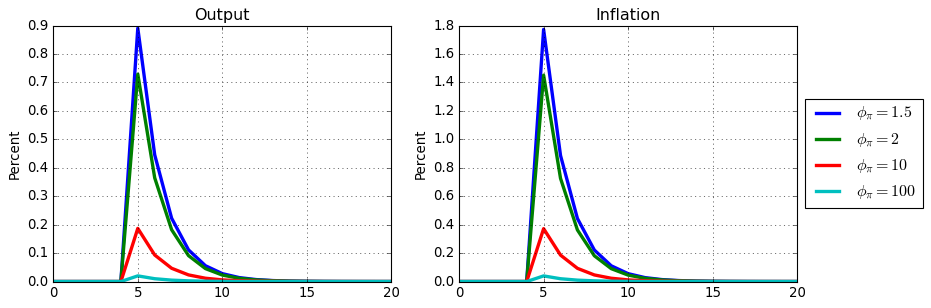

In [3]:
# Create a variable called 'phi_pi_values' that stores the values for phi_pi provided above.
phi_pi_values = [1.5,2,10,100]

# Create a figure with dimensions 12x4. PROVIDED
fig = plt.figure(figsize=(12,4))

# Create the left axis. PROVIDED
ax1 = fig.add_subplot(1,2,1)
# Create the right axis. PROVIDED
ax2 = fig.add_subplot(1,2,2)

# Set the title of the left axis. PROVIDED
ax1.set_title('Output')
# Set the title of the right axis. PROVIDED
ax2.set_title('Inflation')

# Set the y-axis label of the left axis. PROVIDED
ax1.set_ylabel('Percent')
# Set the y-axis label of the right axis. PROVIDED
ax2.set_ylabel('Percent')

# Construct a for loop that iterates over the values in phi_pi
for phi_pi in phi_pi_values:
    
    # Set the phi_pi value in nk_model.parameters to the current value of phi_pi
    nk_model.parameters['phi_pi'] = phi_pi
    
    # Approximate and solve the model. Set log_linear argument to False since the model is already linear
    nk_model.approximate_and_solve(log_linear=False)
    
    # Compute impulse responses to a one percent shock to demand. Set `normalize=False` in `.impulse()` because the steady state contains zeros
    nk_model.impulse(T=21,t0=5,shocks=[0.01,0],normalize=False)
    
    # Plot output
    (nk_model.irs['e_g']['y']*100).plot(ax=ax1,grid=True,lw=3)
    
    # Plot inflation impulse response
    (nk_model.irs['e_g']['pi']*400).plot(ax=ax2,grid=True,lw=3,label='$\\phi_{\\pi}='+str(phi_pi)+'$')
    
# Construct legend. PROVIDED
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5));

**Questions**

1. How do the computed impulse responses for output change as $\phi_{\pi}$ increases from 1.5 to 100?
2. How do the computed impulse responses for inflation change as $\phi_{\pi}$ increases from 1.5 to 100?
3. Does the central banker face a trade-off between stabilizing output fluctuations or stabilizing inflation fluctuations in the presence of a demand shock?

**Answers**

1. The magnitude of the output response declines as $\phi_{\pi}$ increases. <!-- answer -->
1. The magnitude of the inflation response declines as $\phi_{\pi}$ increases. <!-- answer -->
3. No. By increasing the nominal interest rate more aggressively in response to rising inflation, the central bank can stabilize *both* output and inflation against a demand shock. <!-- answer -->

## Exercise: Inflation Shocks and $\phi_{\pi}$

For $\phi_{\pi} = 1.5,2,10,100$, compute impulse responses for output and inflation to a 0.01/4 unit increase in $u_t$. Simulate a total of 21 periods with the arriving in period 5. Construct a figure with two axes side-by-side with output ploted on the left and inflation plotted on the right.

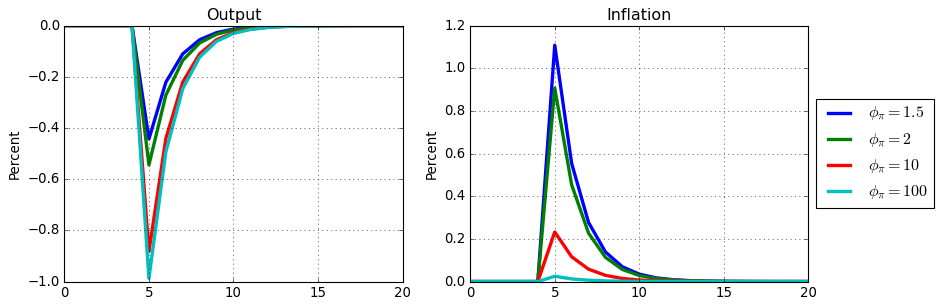

In [4]:
# Create a variable called 'phi_pi_values' that stores the values for phi_pi provided above.
phi_pi_values = [1.5,2,10,100]

# Create a figure with dimensions 12x4. PROVIDED
fig = plt.figure(figsize=(12,4))

# Create the left axis. PROVIDED
ax1 = fig.add_subplot(1,2,1)
# Create the right axis. PROVIDED
ax2 = fig.add_subplot(1,2,2)

# Set the title of the left axis. PROVIDED
ax1.set_title('Output')
# Set the title of the right axis. PROVIDED
ax2.set_title('Inflation')

# Set the y-axis label of the left axis. PROVIDED
ax1.set_ylabel('Percent')
# Set the y-axis label of the right axis. PROVIDED
ax2.set_ylabel('Percent')

# Construct a for loop that iterates over the values in phi_pi
for phi_pi in phi_pi_values:
    
    # Set the phi_pi value in nk_model.parameters to the current value of phi_pi
    nk_model.parameters['phi_pi'] = phi_pi
    
    # Approximate and solve the model. Set log_linear argument to False since the model is already linear
    nk_model.approximate_and_solve(log_linear=False)
    
    # Compute impulse responses to a one percent shock to supply. Set `normalize=False` in `.impulse()` because the steady state contains zeros
    nk_model.impulse(T=21,t0=5,shocks=[0.0,0.01/4],normalize=False)
    
    # Plot output
    (nk_model.irs['e_u']['y']*100).plot(ax=ax1,grid=True,lw=3)
    
    # Plot inflation impulse response
    (nk_model.irs['e_u']['pi']*400).plot(ax=ax2,grid=True,lw=3,label='$\\phi_{\\pi}='+str(phi_pi)+'$')
    
# Construct legend. PROVIDED
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5));

**Questions**

1. How do the computed impulse responses for output change as $\phi_{\pi}$ increases from 1.5 to 100?
2. How do the computed impulse responses for inflation change as $\phi_{\pi}$ increases from 1.5 to 100?
3. Does the central banker face a trade-off between stabilizing output fluctuations or stabilizing inflation fluctuations in the presence of an inflation shock?

**Answers**

1. The magnitude of the output response increases as $\phi_{\pi}$ increases. <!-- answer -->
1. The magnitude of the inflation response declines as $\phi_{\pi}$ increases. <!-- answer -->
3. Yes. By increasing the nominal interest rate more aggressively in response to rising inflation, the central bank improves inflation stability at the cost of making output more volatile against an inflation shock. <!-- answer -->